In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
  
pd.set_option("display.max_columns", None)

In [ ]:
#rewrite xlsx files into pickles with only acclero data (+human readable timestamps) + classes

make_pickles=False

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

@static_vars(pred_val=-1.0)
def to_ts(x):
  try:
    f_msecs=float(str(x))
    to_ts.pred_val=f_msecs
  except:
    f_msecs=to_ts.pred_val
    print("wrong ts data: {}, reset it to {}".format(str(x), f_msecs))
    
  return pendulum.from_timestamp(f_msecs/1000.0)
                                  
def apply_complex_function(x):                                
  return to_ts(x['timestamp_WD'])

d = {0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 2:'Accelerometer_y_WD', 3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 5:'Linear_acceleration_sensor_y_WD', 6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 8:'Gyroscope_y_WD', 9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 11:'Magnetometer_y_WD', 12:'Magnetometer_z_WD', 
     13:'Pressure_sensor_WD', 14:'Heart_rate_sensor_WD',
    15:'GAP', 
     16:'sevtimestamp_PD', 
     17:'Accelerometer_x_PD', 18:'Accelerometer_y_PD', 19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 21:'Linear_acceleration_sensor_y_PD', 22:'Linear_acceleration_sensor_z_PD', 
     23:'Gyroscope_x_PD', 24:'Gyroscope_y_PD',25:'Gyroscope_z_PD', 
     26:'Magnetometer_x_PD', 27:'Magnetometer_y_PD', 28:'Magnetometer_z_PD', 
     29:'GPS_lat_PD',30:'GPS_long_PD', 
     31:'Class_label'}

if make_pickles:
    
    for f_in in os.listdir('UT_Smoking_Data'):  

       if not f_in.endswith('.xlsx') : continue 

       f_out=f_in.replace(".xlsx", ".pickle")
       print("processing {} to {}".format(f_in, f_out))

       f_in = os.path.join('UT_Smoking_Data', f_in)

       print("reading raw {}".format(f_in))
       data = pd.read_excel(f_in, header=None)
       print("got {} rows".format(len(data)))

       try:
         data_rn = data.rename(d, axis=1); del data
         data = data_rn[['timestamp_WD', 'Accelerometer_x_WD', 
                  'Accelerometer_y_WD', 'Accelerometer_z_WD', 
                  'Linear_acceleration_sensor_x_WD', 'Linear_acceleration_sensor_y_WD',
                  'Linear_acceleration_sensor_z_WD', 'Class_label']].copy() ; del data_rn
         print("start ts to dt...")
         data['timestamp_WD']=data.apply(apply_complex_function, axis=1)

         print("writng pickle {}".format(f_out))

         data.to_pickle('UT_Smoking_Data/' + f_out) 

       except: 
         print("failed on {}".format(f_out))

In [38]:
data = pd.read_pickle('UT_Smoking_Data_pickles/Participant1_Data.pickle')

In [39]:
data.shape

(904400, 8)

In [4]:
data['Class_label'].unique()

array(['SmokeSD', 'SmokeST', 'Eat', 'DrinkSD', 'DrinkST', 'Stand', 'Sit'],
      dtype=object)

In [40]:
def to_255(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * 255

#our 3 rgb  
fileds=['Accelerometer_x_WD', 'Accelerometer_y_WD', 'Accelerometer_z_WD'] 

#color weights
fileds_facts={ "Accelerometer_x_WD":5.0, "Accelerometer_y_WD": 5.0, "Accelerometer_z_WD": 1.0 }

res_x=50 #sampling rate
res_y=50 #wind size in secs

tot_frame_len=res_x*res_y

act_types=data['Class_label'].unique()
n_act_types=len(act_types)

data_act={}
act_rgb={}

for act_type in act_types :
  data_act[act_type] = data.loc[data['Class_label'] == act_type ]
  act_rgb[act_type]=[]
    
while True:
    all_exausted=True  
    
    for act_type in act_types :         
      if len(data_act[act_type]) < tot_frame_len : continue
        
      data_tmp=data_act[act_type].head(res_x*res_y)

      #fill rgb frame from df...
      raw_data = []  
      for nth_sec in range(1,res_y+1):
        for nrow in range(1,res_x+1):
           row=data_tmp.iloc[nrow-1]
           for fld in fileds:
             raw_data.append(row[fld] * fileds_facts[fld])
        data_tmp = data_tmp.iloc[res_x:,:]

      act_rgb[act_type].append(Image.fromarray(np.array(to_255(raw_data), dtype=np.uint8).reshape(res_x,res_y,3)))
      
      all_exausted=False
    
      data_act[act_type] = data_act[act_type].iloc[tot_frame_len:,:]
           
    if all_exausted : break

In [41]:
for act_type in act_types :    
  print("made {} frames for activty {}".format(len(act_rgb[act_type]), act_type))

made 51 frames for activty SmokeSD
made 51 frames for activty SmokeST
made 51 frames for activty Eat
made 51 frames for activty DrinkSD
made 51 frames for activty DrinkST
made 51 frames for activty Sit
made 51 frames for activty Stand


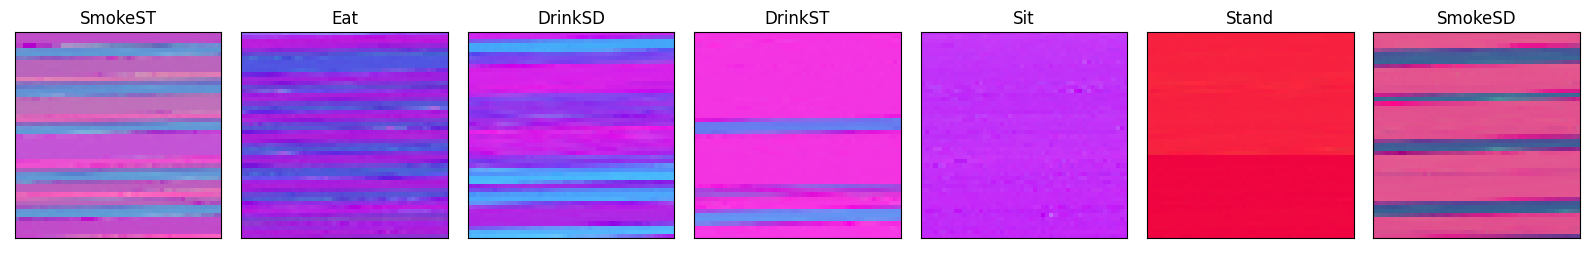

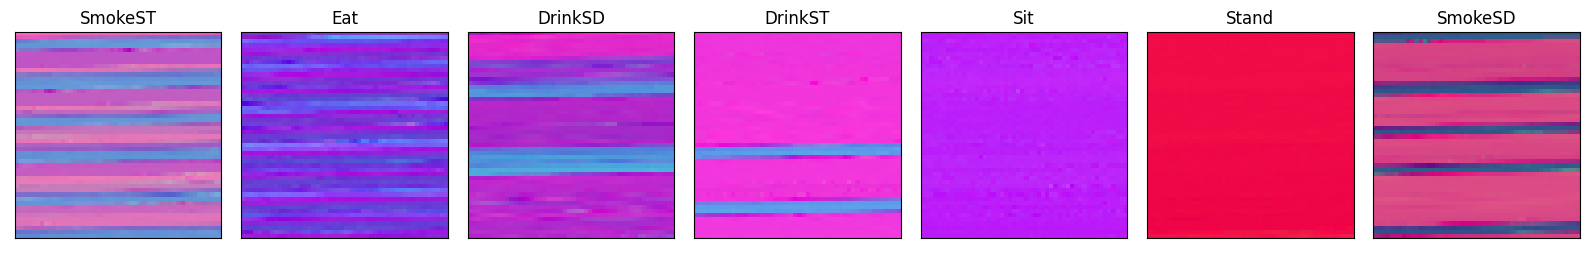

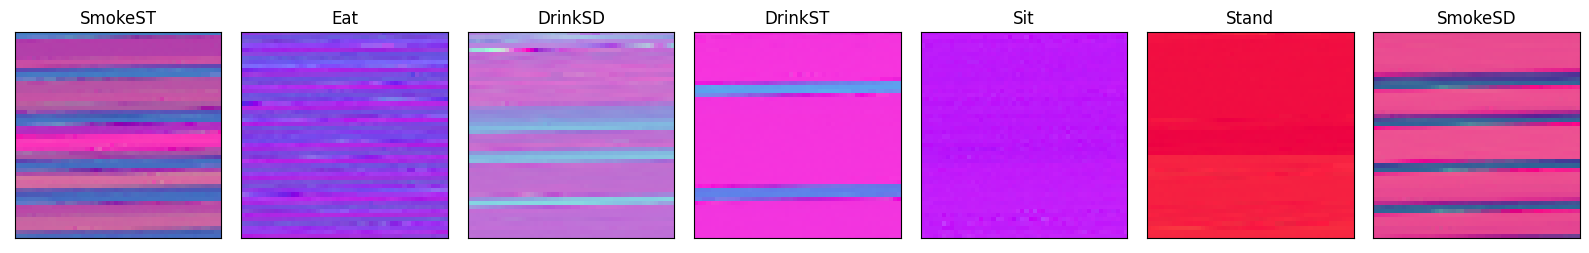

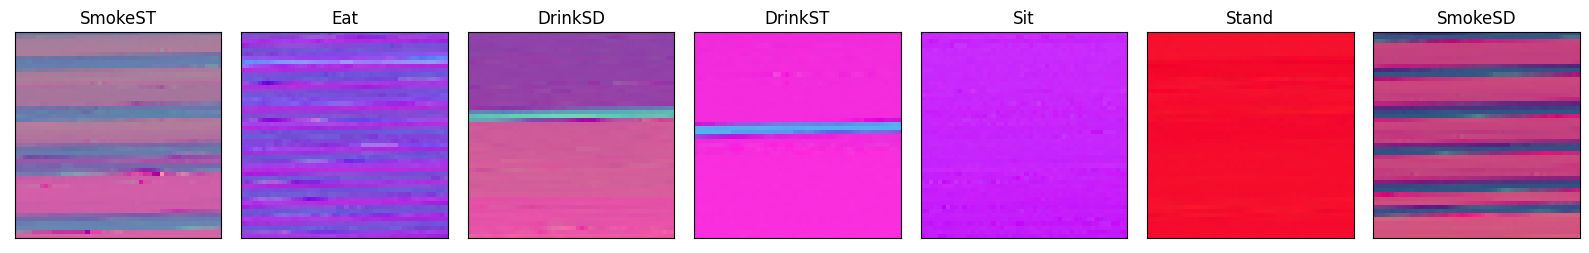

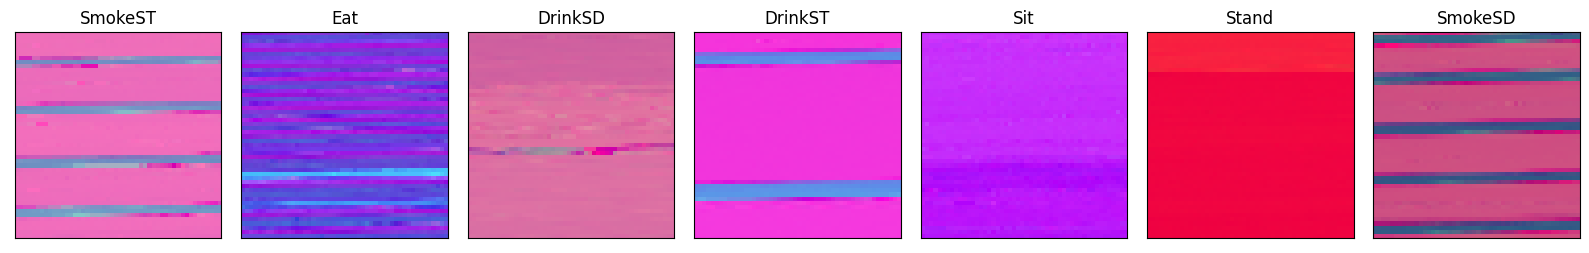

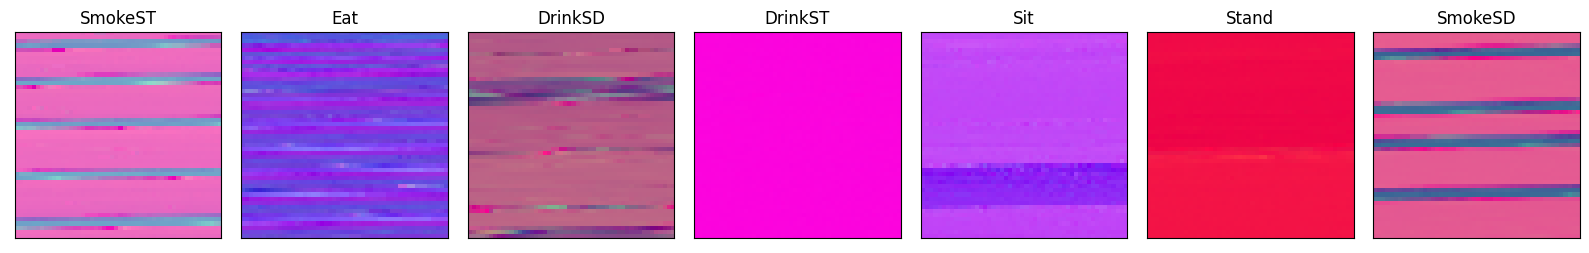

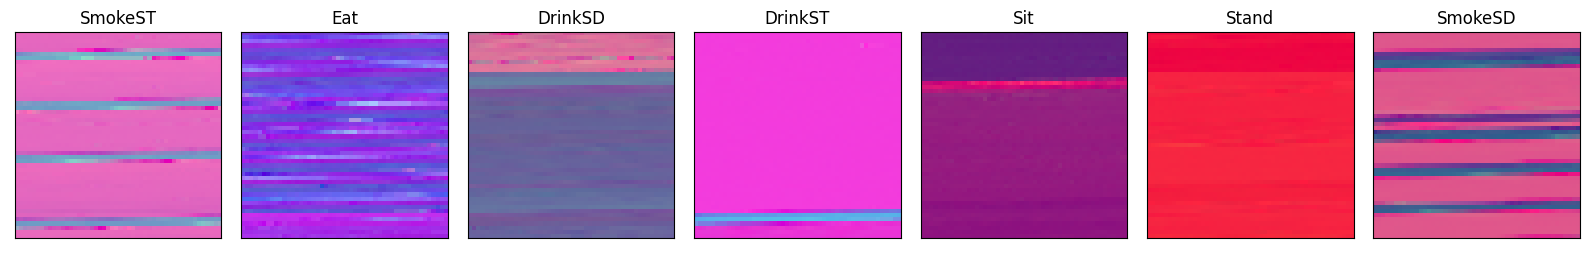

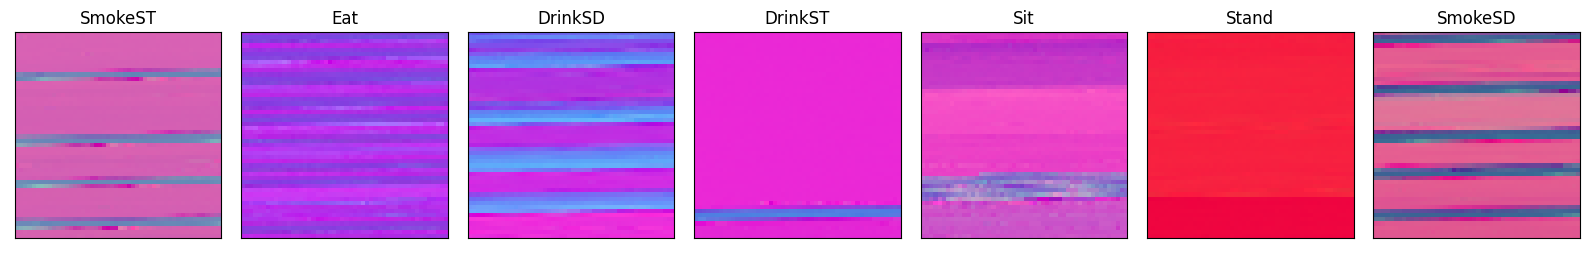

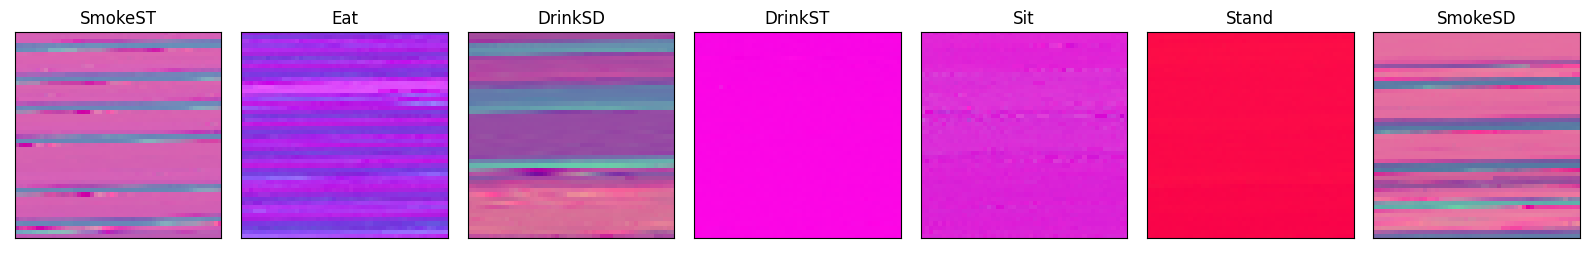

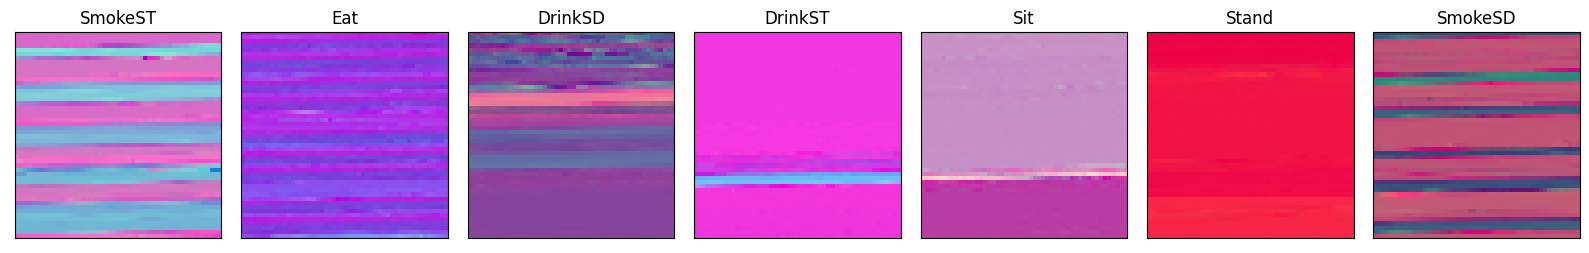

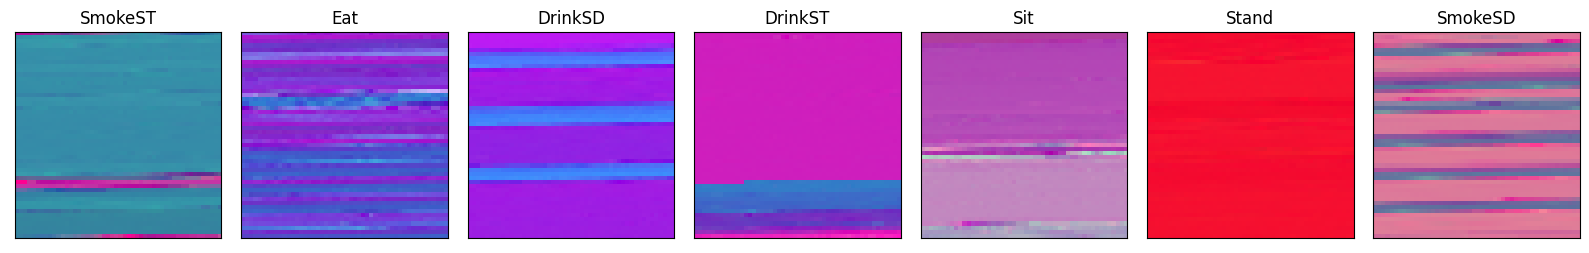

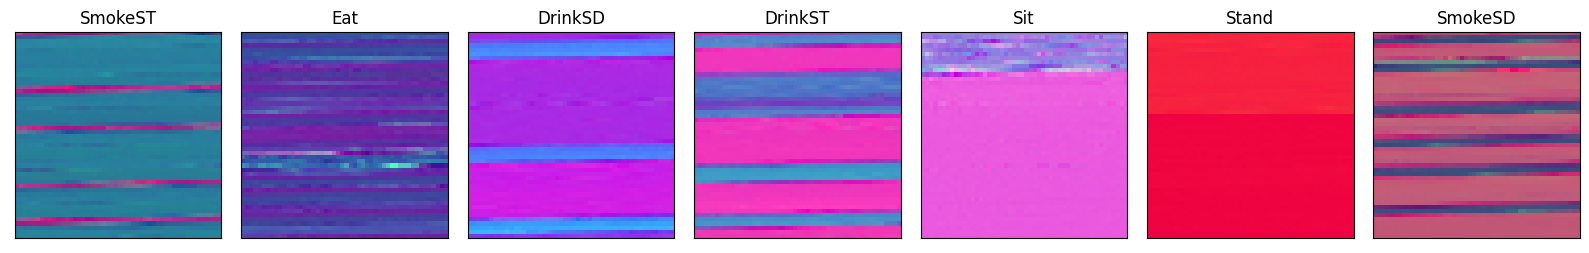

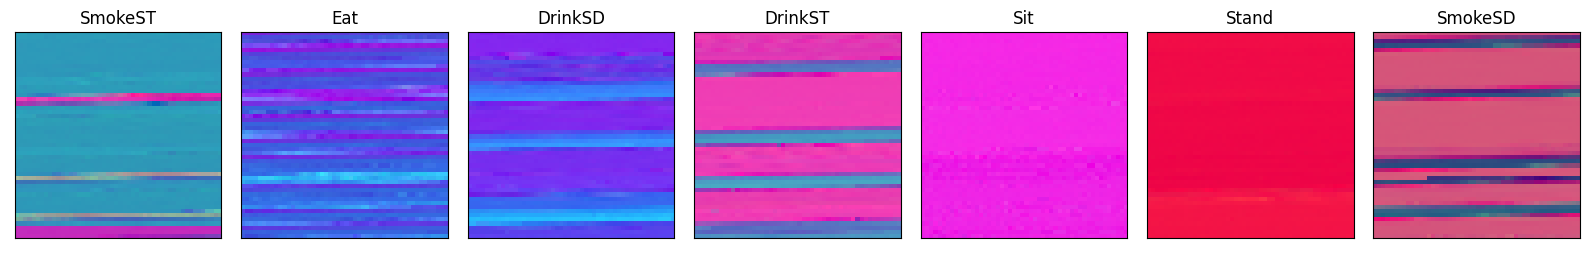

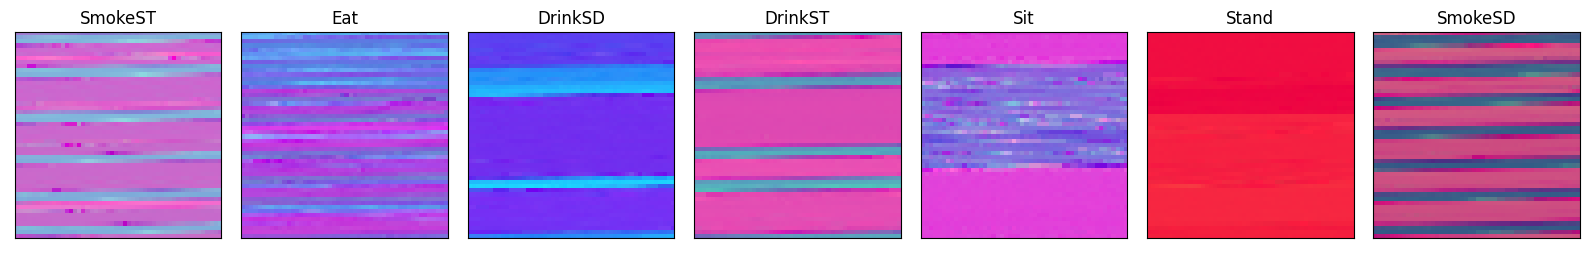

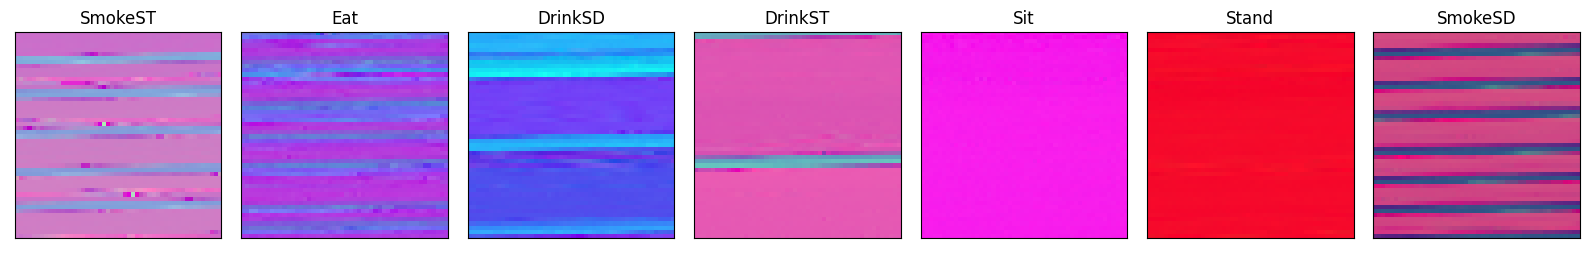

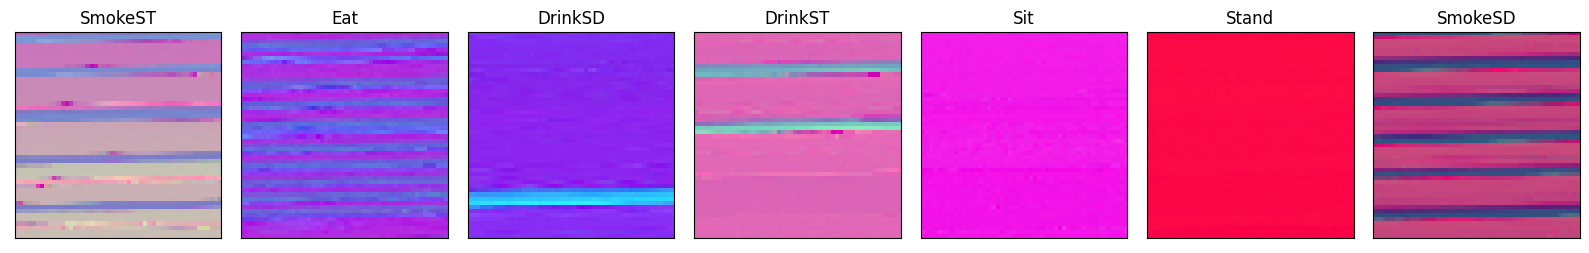

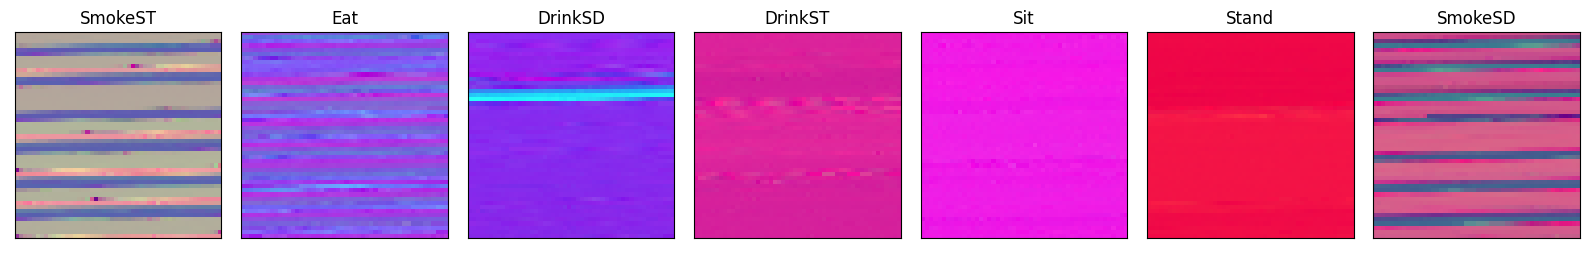

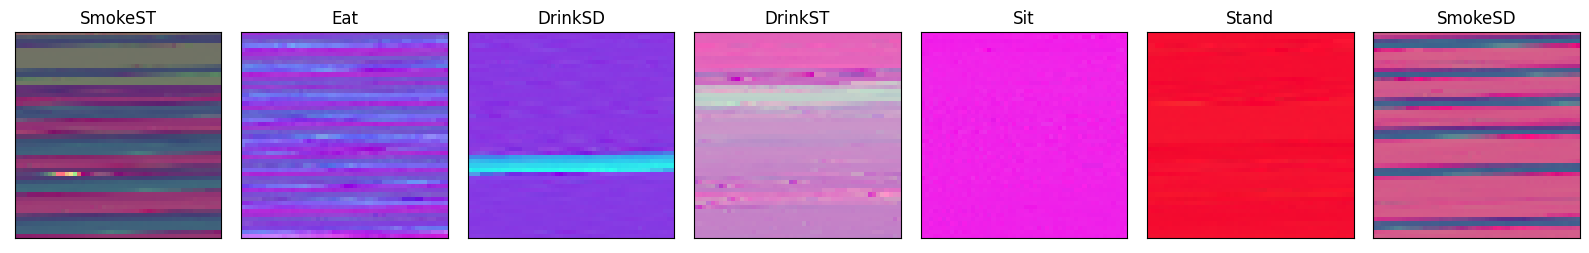

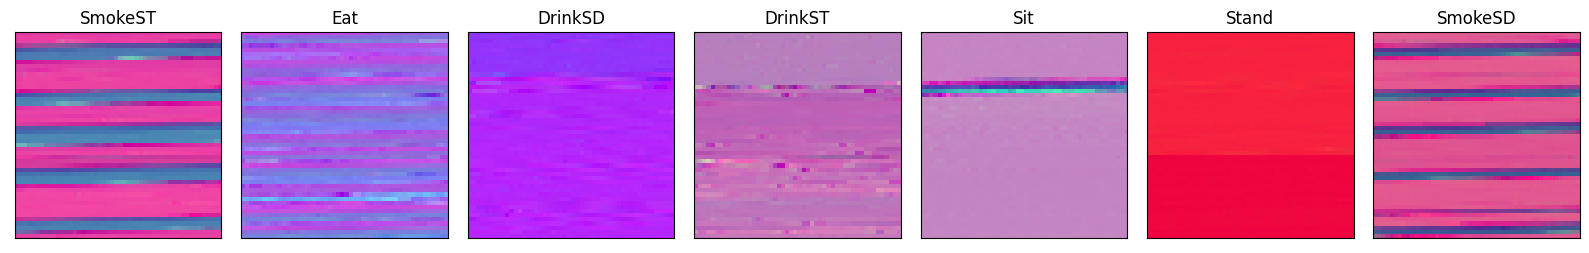

In [42]:
for n_row in range(1,20):
  n_act=0
  fig, axs = plt.subplots(1, n_cols, figsize=(16, 9))
  for i in range(n_cols):
    ax = axs[i-1]
    ax.set_title(f'{act_types[n_act]}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(act_rgb[act_types[n_act]][n_row])
    n_act+=1
  plt.tight_layout()